### Imports

In [1]:
import pandas as pd
from tensorflow.keras.models import load_model
import joblib
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

In [2]:
lstm_future = load_model('best_lstm_model2.h5')
classification = load_model('best_classification_model.h5')

std_scaler = joblib.load('std_scaler.pkl')
yield_scaler = joblib.load('yield_scaler.pkl')

data = pd.read_csv('data/merged_data.csv')
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)
data.sort_index(inplace=True)

### Predict 4 months ahead then classify

In [3]:
# Drop Recession column (will be used in classification model)
data_future = data.drop(columns=['Recession'], errors='ignore')
future_recession = data['Recession'].shift(-1)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_future)

# Convert the data into sequences
def create_sequences(data_future, look_back):
    X, y = [], []
    for i in range(len(data_future) - look_back- 3):
        X.append(data_future[i:i + look_back])
        y.append(future_recession[i + look_back + 3]) #look forward 4 months
    return np.array(X), np.array(y)

look_back = 12  # Use the past 12 months to predict the next month
X, y = create_sequences(scaled_data, look_back)


probabilities = []
prediction_dates = data.index[look_back + 3:]  # Align with prediction dates

# Predict and inverse transform the results
for i in range(len(X)-3):
    temp = (X[i].reshape(1, look_back, X.shape[2])) #stores current data as well as the future 4 (acts like a queue)

    future_steps = 4  
    predictions = []
    for _ in range(4):
        prediction = lstm_future.predict(temp.reshape(1, look_back, X.shape[2]))
        predictions.append(prediction[0]) # Store the prediction
        temp = temp[:, 1:, :]  # Pop oldest month
        new_step = prediction.reshape(1, 1, -1)  # Reshape to the correct size
        temp = np.concatenate([temp, new_step], axis=1)  # Add prediction to queue
        #repeat for 4 months

    predictions = pd.DataFrame(predictions)
    predictions = scaler.inverse_transform(predictions) #inverse transform the predictions
    predictions = pd.DataFrame(predictions, columns=data_future.columns)

    # Prepare the data for classification model
    standard_scaler_columns = ['Slope', 'LongTermRate' ]
    min_max_scaler_columns = ['ZeroCouponYield1Y', 'ZeroCouponYield10Y']

    #Apply StandardScaler to selected columns
    standard_scaler = StandardScaler()
    predictions[standard_scaler_columns] = standard_scaler.fit_transform(predictions[standard_scaler_columns])

    # Apply MinMaxScaler to the yield data
    yield_scaler = MinMaxScaler()
    flat = predictions[min_max_scaler_columns].values.flatten().reshape(-1, 1) 
    yield_scaler.fit(flat) # fit scaler on both collumns to calculate based on global min max
    predictions[min_max_scaler_columns] = yield_scaler.transform(predictions[min_max_scaler_columns].values.flatten().reshape(-1, 1)).reshape(len(predictions), 2)

    # Predict the probability of recession
    probability = classification.predict(predictions.to_numpy().reshape(1, future_steps, X.shape[2]))
    probabilities.append(probability[0][0])



1/1 [==============================] - 0s 18ms/step


### View future Probabilies

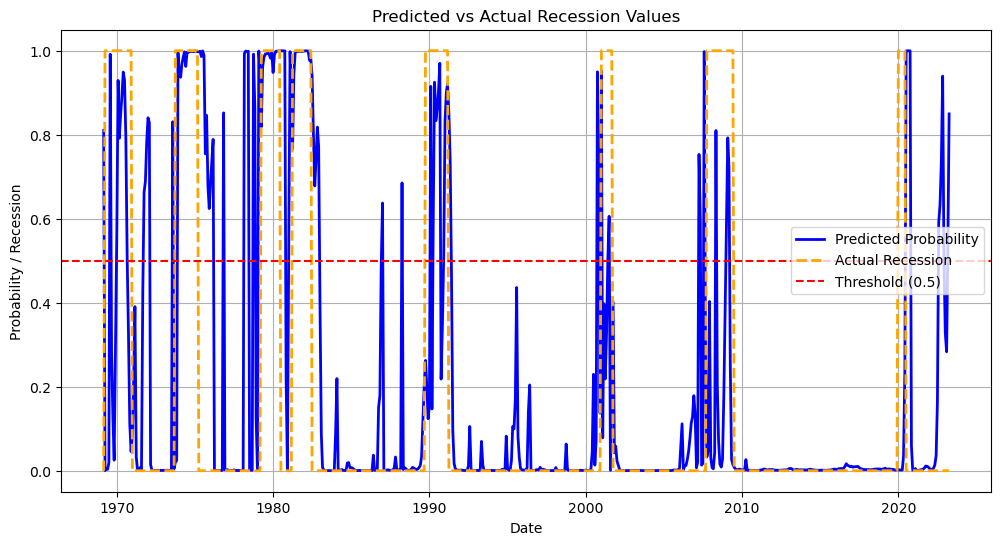

In [4]:
# Align dates for predictions and actual values
aligned_dates = data.index[look_back + 3:len(probabilities) + look_back + 3]

# Create a DataFrame for predicted probabilities and actual values
plot_df = pd.DataFrame({
    'Date': aligned_dates,
    'Predicted Probability': probabilities,
    'Actual Recession': y[:len(probabilities)]  # Match the actual values with probabilities
}).set_index('Date')

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(plot_df.index, plot_df['Predicted Probability'], label='Predicted Probability', color='blue', linewidth=2)
plt.plot(plot_df.index, plot_df['Actual Recession'], label='Actual Recession', color='orange', linewidth=2, linestyle='--')
plt.axhline(0.5, color='red', linestyle='--', label='Threshold (0.5)')
plt.title('Predicted vs Actual Recession Values')
plt.xlabel('Date')
plt.ylabel('Probability / Recession')
plt.legend()
plt.grid()
plt.show()

### Apply thresholding

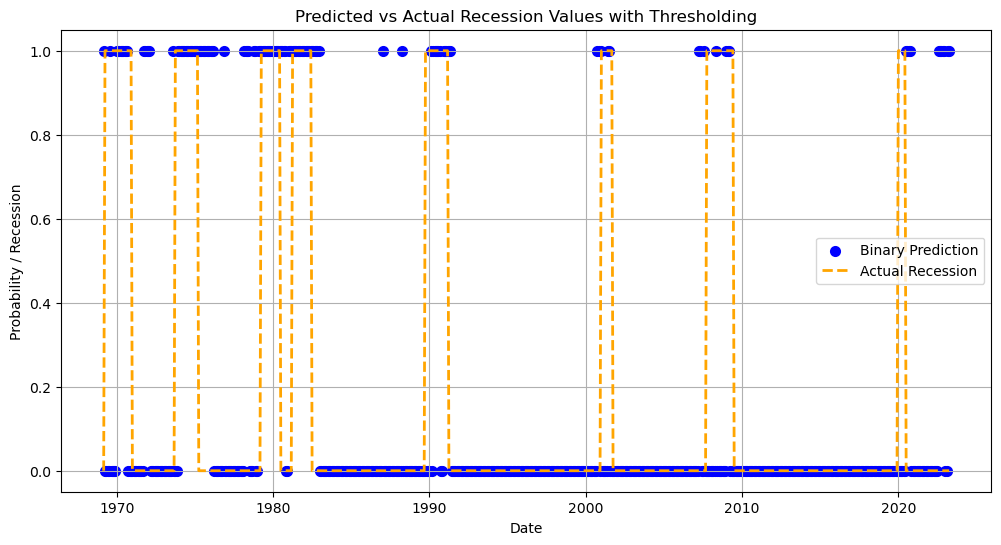

In [5]:
# Thresholding to probabilities
binary_predictions = (np.array(probabilities) >= 0.5).astype(int)

# Create a DataFrame for predicted probabilities, binary predictions, and actual values
plot_df = pd.DataFrame({
    'Date': aligned_dates,
    'Binary Prediction': binary_predictions,  # After threshold predictions
    'Actual Recession': y[:len(probabilities)]  # Match the actual values with probabilities
}).set_index('Date')

# Plot the data
plt.figure(figsize=(12, 6))
plt.scatter(plot_df.index, plot_df['Binary Prediction'], label='Binary Prediction', color='blue', linewidth=2 )
plt.plot(plot_df.index, plot_df['Actual Recession'], label='Actual Recession', color='orange', linewidth=2, linestyle='--')

plt.title('Predicted vs Actual Recession Values with Thresholding')
plt.xlabel('Date')
plt.ylabel('Probability / Recession')
plt.legend()
plt.grid()
plt.show()


### Evaluate

Accuracy: 0.83
Precision: 0.55
Recall: 0.60
F1-Score: 0.57

Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.88      0.89       527
         1.0       0.55      0.60      0.57       123

    accuracy                           0.83       650
   macro avg       0.73      0.74      0.73       650
weighted avg       0.84      0.83      0.83       650



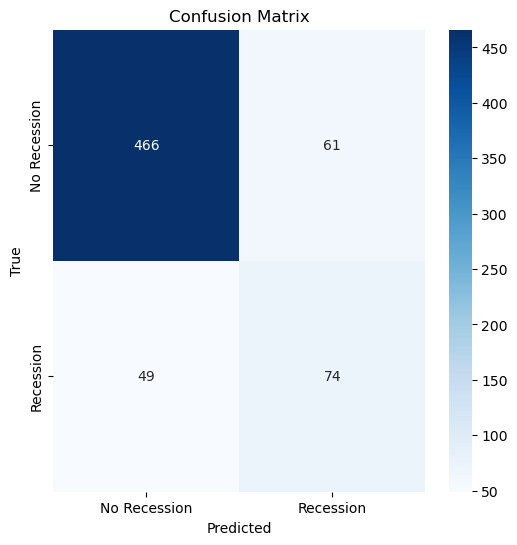

In [6]:
# Calculate metrics
y_true = plot_df['Actual Recession']  # True values
y_pred = plot_df['Binary Prediction']  # Predicted values

# Compute classification metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Display the metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Visualize the Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Recession', 'Recession'],
            yticklabels=['No Recession', 'Recession'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
